In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from abc import ABC, abstractmethod
import time

Simulación del sistema masa-resorte:
Ingrese el número de masas (n): 3
Ingrese el valor de k1 (positivo): 1
Ingrese el valor de k2 (positivo): 2
Ingrese el valor de k3 (positivo): 3
Ingrese el valor de k4 (positivo): 4
Ingrese el valor de m1 (positivo): 5
Ingrese el valor de m2 (positivo): 6
Ingrese el valor de m3 (positivo): 4
Ingrese la velocidad inicial v1(0): 7
Ingrese la velocidad inicial v2(0): 1
Ingrese la velocidad inicial v3(0): 2
Ingrese el desplazamiento inicial x1(0): 3
Ingrese el desplazamiento inicial x2(0): 4
Ingrese el desplazamiento inicial x3(0): 8
Tiempo de ejecución de simular: 0.0056 segundos


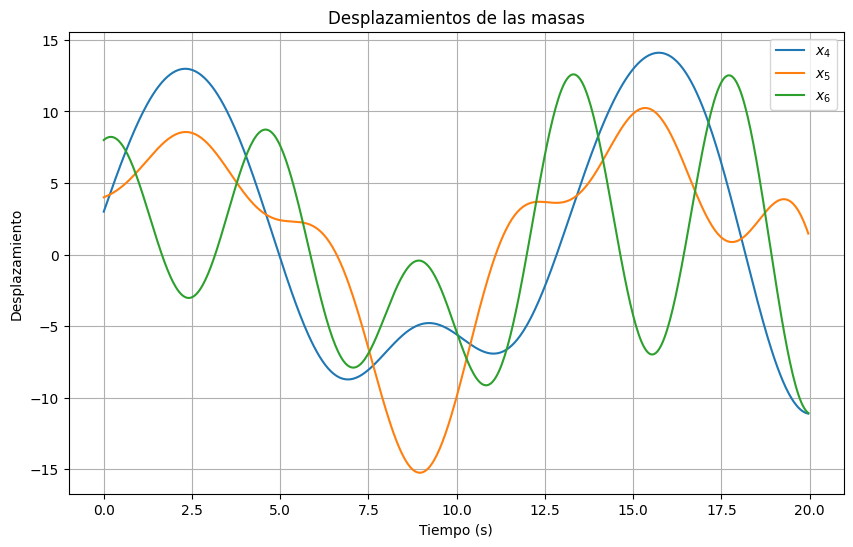

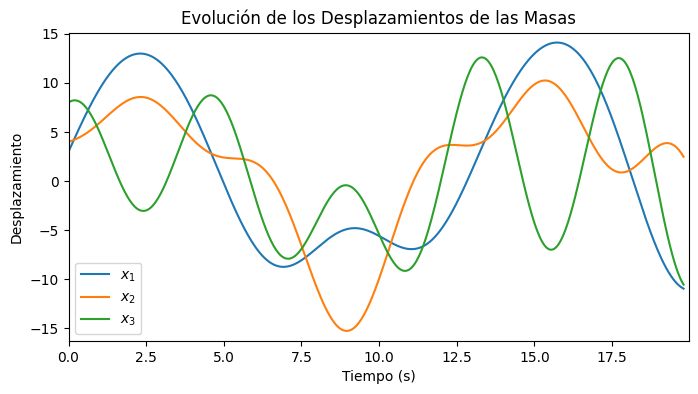

In [9]:

# Decorador para medir el tiempo de ejecución
def time_execution(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Tiempo de ejecución de {func.__name__}: {end_time - start_time:.4f} segundos")
        return result
    return wrapper

# Decorador para caching, adaptado para manejar listas sin numpy
def cache_results(func):
    cached_values = {}
    def wrapper(*args):
        # Convertir listas en tuplas para que sean hashables
        hashable_args = tuple(tuple(arg) if isinstance(arg, list) else arg for arg in args)
        if hashable_args in cached_values:
            return cached_values[hashable_args]

        result = func(*args)
        cached_values[hashable_args] = result
        return result
    return wrapper

# Clase abstracta Movimiento
class Movimiento(ABC):
    def __init__(self, tiempo_simulacion, condiciones_iniciales):
        self._tiempo_simulacion = tiempo_simulacion
        self._condiciones_iniciales = condiciones_iniciales
        self.t = [tiempo_simulacion * i / 500 for i in range(500)]  # Simulamos 500 pasos
        self.sol = None

    @property
    def tiempo_simulacion(self):
        return self._tiempo_simulacion

    @tiempo_simulacion.setter
    def tiempo_simulacion(self, valor):
        if valor > 0:
            self._tiempo_simulacion = valor

    @property
    def condiciones_iniciales(self):
        return self._condiciones_iniciales

    @abstractmethod
    def ecuacion_diferencial(self, t, y):
        pass

    @time_execution
    def simular(self):
        y = self._condiciones_iniciales
        sol = [y]
        dt = self.t[1] - self.t[0]
        for ti in self.t[1:]:
            dy = self.ecuacion_diferencial(ti, y)
            y = [y[i] + dy[i] * dt for i in range(len(y))]
            sol.append(y)
        self.sol = sol

    def mostrar_resultados(self):
        plt.figure(figsize=(10, 6))
        for i in range(len(self.sol[0]) // 2, len(self.sol[0])):
            plt.plot(self.t, [s[i] for s in self.sol], label=f"$x_{i+1}$")
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Desplazamiento")
        plt.legend()
        plt.title("Desplazamientos de las masas")
        plt.grid(True)
        plt.show()

    def animar_grafica(self, filename='grafica_dinamica.gif'):
        fig, ax = plt.subplots(figsize=(8, 4))  # Tamaño reducido para mejorar rendimiento
        ax.set_xlim(0, self.t[-1])
        max_disp = max(max(s[len(s)//2:]) for s in self.sol)
        min_disp = min(min(s[len(s)//2:]) for s in self.sol)
        ax.set_ylim(min_disp - 1, max_disp + 1)

        lineas = [ax.plot([], [], label=f"$x_{i+1}$")[0] for i in range(len(self.sol[0]) // 2)]
        ax.set_xlabel("Tiempo (s)")
        ax.set_ylabel("Desplazamiento")
        ax.legend()
        ax.set_title("Evolución de los Desplazamientos de las Masas")

        def init():
            for linea in lineas:
                linea.set_data([], [])
            return lineas

        def update(frame):
            for i, linea in enumerate(lineas):
                linea.set_data(self.t[:frame], [s[len(self.sol[0]) // 2 + i] for s in self.sol[:frame]])
            return lineas

        # Reduce el número de frames y FPS para acelerar el guardado
        anim = FuncAnimation(fig, update, frames=range(1, len(self.t), 5), init_func=init, blit=True, interval=50)
        anim.save(filename, writer=PillowWriter(fps=10))  # FPS reducido
        plt.show()

# Clase MasaResorte que hereda de Movimiento
class MasaResorte(Movimiento):
    def __init__(self, n, k, m, tiempo_simulacion, condiciones_iniciales):
        super().__init__(tiempo_simulacion, condiciones_iniciales)
        self._n = n
        self._k = k
        self._m = m

    @cache_results
    def ecuacion_diferencial(self, t, y):
        v = y[:self._n]
        x = y[self._n:]
        a = [0] * self._n

        for i in range(self._n):
            if i > 0:
                a[i] += (self._k[i] / self._m[i]) * (x[i - 1] - x[i])
            if i < self._n - 1:
                a[i] += (self._k[i + 1] / self._m[i]) * (x[i + 1] - x[i])
            if i == 0:
                a[i] += (self._k[0] / self._m[i]) * (-x[i])
            if i == self._n - 1:
                a[i] += (self._k[self._n] / self._m[i]) * (-x[i])

        return a + v

# Funciones para solicitar valores válidos
def solicitar_entero_positivo(mensaje):
    while True:
        try:
            valor = int(input(mensaje))
            if valor > 0:
                return valor
            else:
                print("El valor debe ser un número entero positivo.")
        except ValueError:
            print("Por favor ingrese un número entero válido.")

def solicitar_constantes_resorte(n):
    k = []
    for i in range(n + 1):
        while True:
            try:
                k_i = float(input(f"Ingrese el valor de k{i + 1} (positivo): "))
                if k_i > 0:
                    k.append(k_i)
                    break
                else:
                    print("La constante del resorte debe ser un valor positivo.")
            except ValueError:
                print("Por favor ingrese un valor numérico.")
    return k

def solicitar_masas(n):
    m = []
    for i in range(n):
        while True:
            try:
                m_i = float(input(f"Ingrese el valor de m{i + 1} (positivo): "))
                if m_i > 0:
                    m.append(m_i)
                    break
                else:
                    print("La masa debe ser un valor positivo.")
            except ValueError:
                print("Por favor ingrese un valor numérico.")
    return m

# Función principal para correr la simulación
def main():
    print("Simulación del sistema masa-resorte:")
    n = solicitar_entero_positivo("Ingrese el número de masas (n): ")
    k = solicitar_constantes_resorte(n)
    m = solicitar_masas(n)
    v0 = [float(input(f"Ingrese la velocidad inicial v{i + 1}(0): ")) for i in range(n)]
    x0 = [float(input(f"Ingrese el desplazamiento inicial x{i + 1}(0): ")) for i in range(n)]
    tiempo_simulacion = 20
    condiciones_iniciales = v0 + x0
    sistema = MasaResorte(n, k, m, tiempo_simulacion, condiciones_iniciales)
    sistema.simular()
    sistema.mostrar_resultados()
    sistema.animar_grafica()

# Ejecutar la simulación
main()


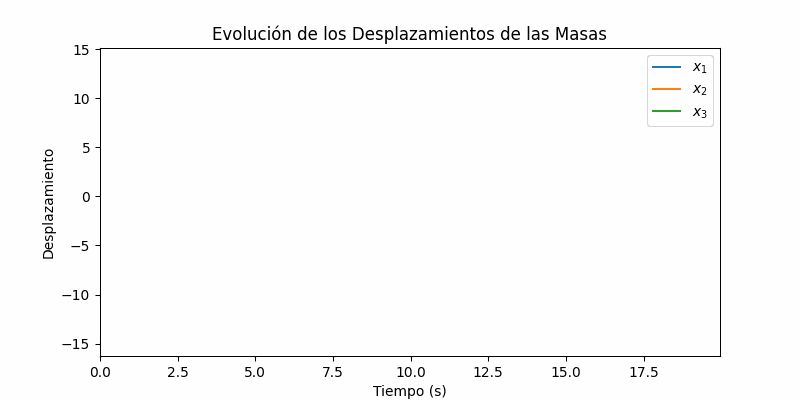

In [10]:
from IPython.display import Image
Image(filename='grafica_dinamica.gif')
